In [1]:
import os
os.environ['DEVELOPMENT'] = 'True'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement, GroundWater
from aquacrop.utils import prepare_weather, get_filepath



INFO:root:Running the simulation in development mode.
c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop\lib\site-packages\aquacrop\solution\root_zone_water.py:4: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC
INFO:root:"C:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Tools\MSVC\14.35.32215\ATLMFC\include" "-IC:\Program Files (x86)\Microsoft Visual Studio\2022\BuildTools\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.

Setup comparison function

In [2]:
def run_comparison(win_filename, py_model):

    # Get Python daily output
    py_daily_outputs = py_model.get_crop_growth()
    py_daily_outputs['biomass']=py_daily_outputs['biomass']/100
    py_daily_outputs['canopy_cover']=py_daily_outputs['canopy_cover']*100
    py_daily_outputs['dap']=py_daily_outputs['dap'].astype(int)

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')
    
    py_daily_outputs['datetime']=py_daily_outputs.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_daily_outputs['year']=pd.DatetimeIndex(py_daily_outputs['datetime']).year
    py_daily_outputs['month']=pd.DatetimeIndex(py_daily_outputs['datetime']).month
    py_daily_outputs['day']=pd.DatetimeIndex(py_daily_outputs['datetime']).day
    py_daily_outputs['source']='AQ-Py'

    # Get Python annual outputs
    py_annual_outputs = py_model._outputs.final_stats.round(3)
    py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry-yield", "fresh-yield","yield-potential", "Seasonal irrigation (mm)"]
    py_annual_outputs['source']='Py'


    # Get windows daily outputs
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    win_daily_outputs=win_daily_outputs.drop([0])
    win_daily_outputs.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')

    # drop rows that contain repetitions of the headers throughout the file, one per successive annual run
    def remove_headers(data):
        start_points=data[data.isin(['Day']).any(axis=1)].index # begin row drops where 'Day' is in any col
        end_points = [x+3 for x in start_points] # end 3 lines later
        to_drop=[]
        n=0

        while(n < len(start_points)):
            x=list(range(start_points[n]-1, end_points[n]-1)) # adjust drops, one line before the indexes found previously
            to_drop.extend(x) # add all indexes to drop to a list
            n=n+1

        new_data = data.drop(index=to_drop)

        return new_data

    win_daily_outputs=remove_headers(win_daily_outputs)
    # add datetime column
    win_daily_outputs['datetime'] = pd.to_datetime(win_daily_outputs[['year','month','day']])
    # convert all cols except date-related cols to floats
    win_daily_outputs['CC']=win_daily_outputs['CC'].astype(float)
    cols=win_daily_outputs.columns.drop(['day','month','year','datetime'])
    win_daily_outputs[cols]=win_daily_outputs[cols].apply(pd.to_numeric, errors='coerce')
    # rename cols to align with py col names
    win_daily_outputs.rename(columns={'CC': 'canopy_cover',
                                'Y(dry)': 'Yield',
                                'Biomass': 'biomass',
                                'HI':'harvest_index',
                                },
                    inplace=True, errors='raise')
    win_daily_outputs['source']='AQ-Win'
    win_daily_outputs.to_csv('win-outputs.csv', index = False, encoding='utf-8')

    # Get windows annual outputs
    win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT', 
                                skiprows=4, skipfooter=8,  delim_whitespace=True,encoding="ISO-8859-1")
    win_annual_outputs=win_annual_outputs.drop([0])
    win_annual_outputs=remove_headers(win_annual_outputs)
    win_annual_outputs = win_annual_outputs.iloc[: , :-5] # remove 5 blank cols due to reading error
    win_annual_outputs['datetime']=pd.to_datetime(win_annual_outputs[['Year','Month','Day']])
    win_annual_outputs.columns=['Nr','Day','Month','Year','biomass','dry-yield','fresh-yield', 'datetime']
    win_annual_outputs=win_annual_outputs[win_annual_outputs['Nr'] != '0'] # remove blank rows
    win_annual_outputs['source']='Win'

    # Combine annual outputs
    combined_annual=pd.concat([win_annual_outputs, py_annual_outputs])
    combined_annual['dry-yield']=combined_annual['dry-yield'].astype(float)

    # Combine daily outputs
    both_daily_outputs=pd.concat([win_daily_outputs, py_daily_outputs])

    g1=sns.lineplot(data=both_daily_outputs, x='datetime',y='canopy_cover', hue='source')
    sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    #g.set_yticks(range(0,110,10), labels=range(0,110,10)) 
    g2=sns.lineplot(data=both_daily_outputs, x='datetime',y='biomass', hue='source')
    sns.move_legend(g2, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g3=sns.lineplot(data=combined_annual.reset_index(), x='datetime', y='dry-yield', hue='source')
    sns.move_legend(g3, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    

Exercise 7.1 with Tunis Local soil

In [3]:
# Tunis climate
filepath=get_filepath('tunis_climate.txt')
weather_data = prepare_weather(filepath)

# Local Tunis soil
tunis_soil = Soil(soil_type='ac_TunisLocal')

# crops
wheat = Crop('WheatGDD', planting_date='10/15')

# IWC
wet_dry = InitialWaterContent(wc_type='Num',
                              method='Depth',
                              depth_layer=[0.3,0.9],
                              value=[0.3,0.15])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=tunis_soil,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LocalSoil', model)

ValueError: Length mismatch: Expected axis has 6 elements, new values have 8 elements

Exercise 7.1 with Sandy Loam

In [ ]:
# Sandy loam soil
sandy_loam = Soil(soil_type='SandyLoam')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_SLSoil', model)

    year     ppm
0   1959  315.98
1   1960  316.91
2   1961  317.64
3   1962  318.45
4   1963  318.99
..   ...     ...
56  2060  563.00
57  2070  601.00
58  2080  639.00
59  2090  674.00
60  2100  703.00

[61 rows x 2 columns]


ValueError: could not convert string to float: 'FC'

Exercise 7.2 Local wheat variety

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\88414398.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\88414398.py:70: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


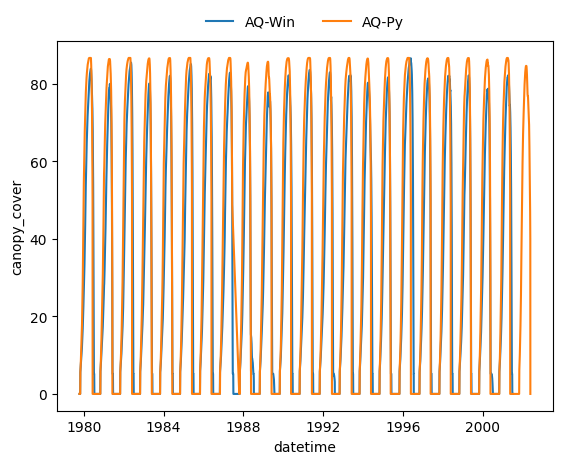

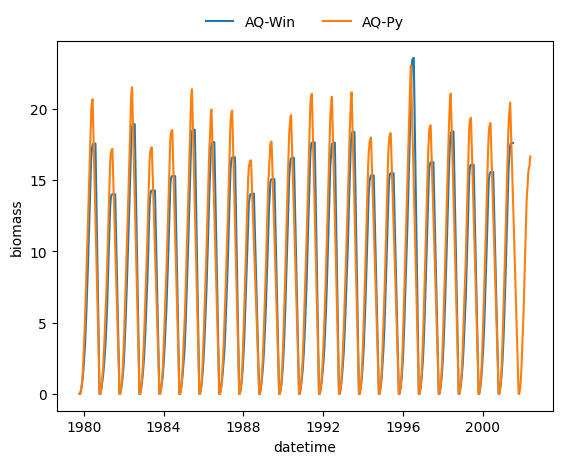

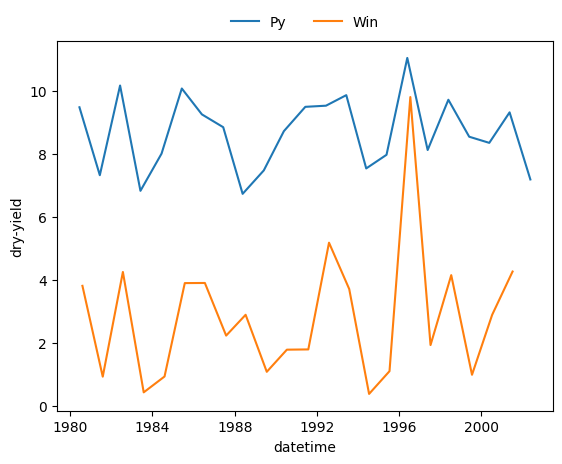

In [ ]:
# Local wheat variety
local_wheat=Crop('WheatLongGDD', planting_date= '10/15')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=local_wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LongVar2', model)

Exercise 7.3 Different initial conditions

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\2112206043.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\2112206043.py:67: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


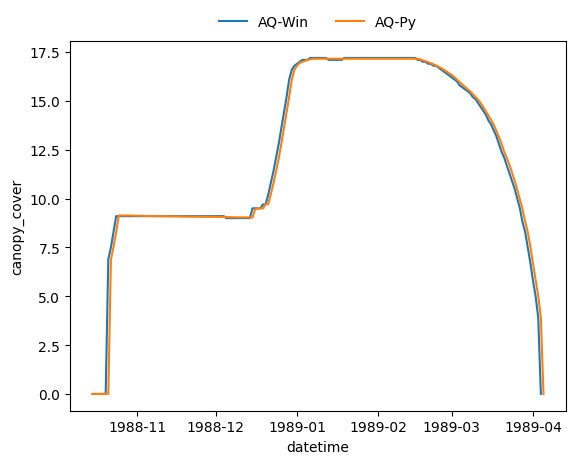

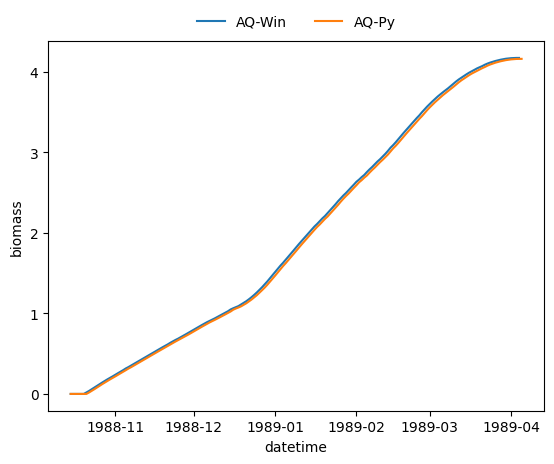

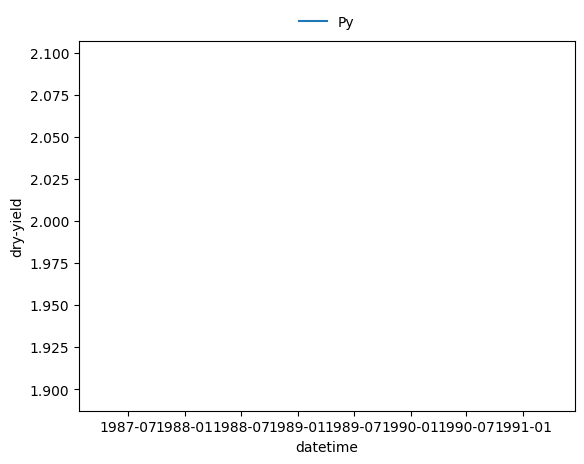

In [ ]:
# Change initial water content (from volumetric %)
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

model = AquaCropModel(sim_start_time=f'{1988}/10/15',
                      sim_end_time=f'{1989}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc30taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_1988_30', model)

Exercise 7.6 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\3030752766.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\3030752766.py:70: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


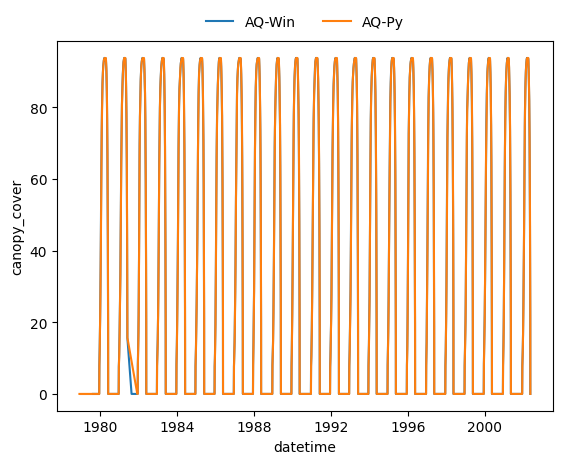

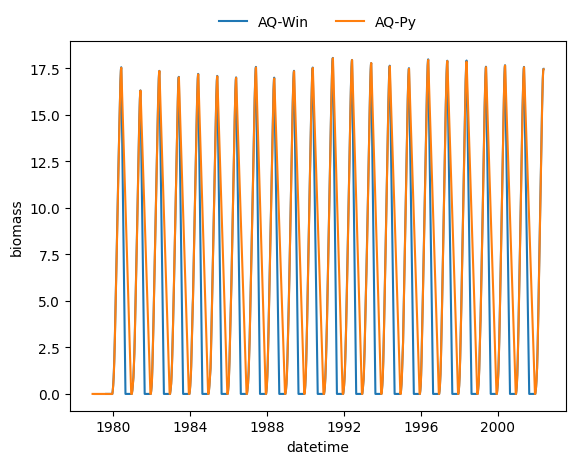

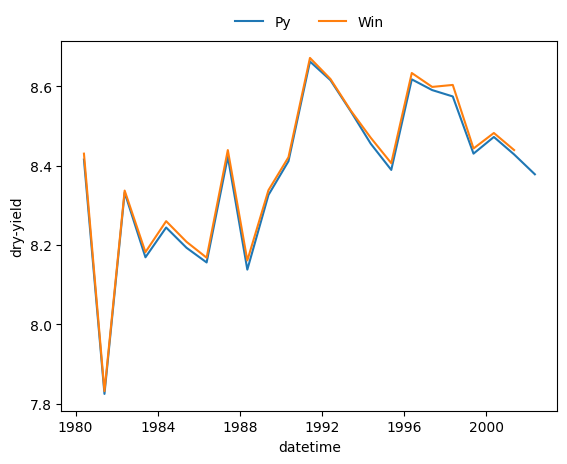

In [ ]:
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

Exercise 8.3 Paddy rice in Hyderabad

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\88414398.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\88414398.py:70: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


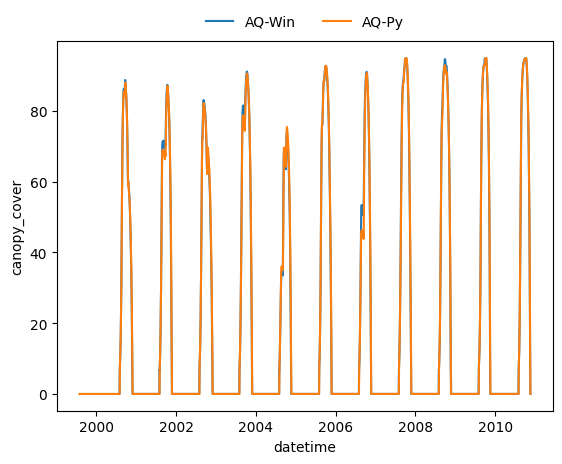

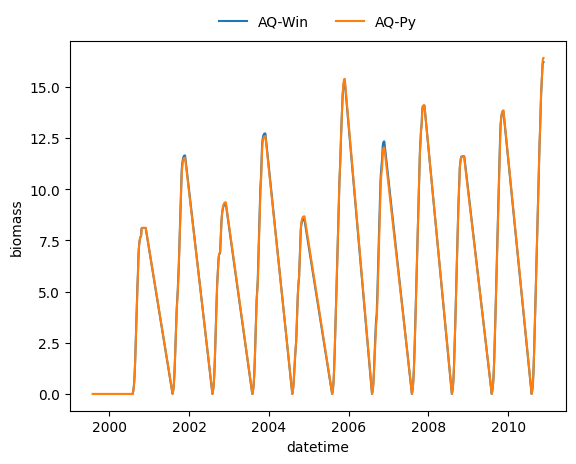

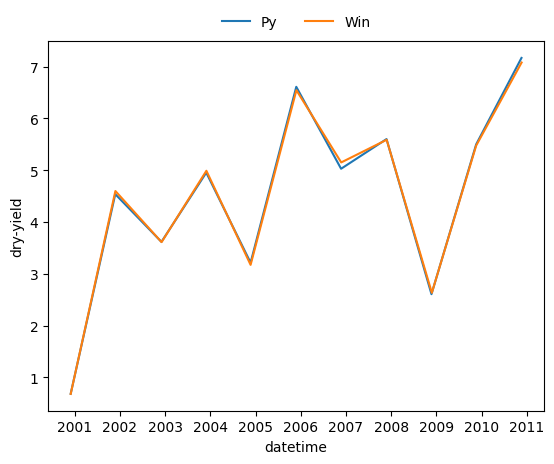

In [ ]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Local Brussels soil
paddy_soil = Soil(soil_type='Paddy')

# crops
rice = Crop('PaddyRiceGDD', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=rice,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyderabad', model)

Exercise 9.1 Potato in Brussels

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\3030752766.py:25: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_8868\3030752766.py:70: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


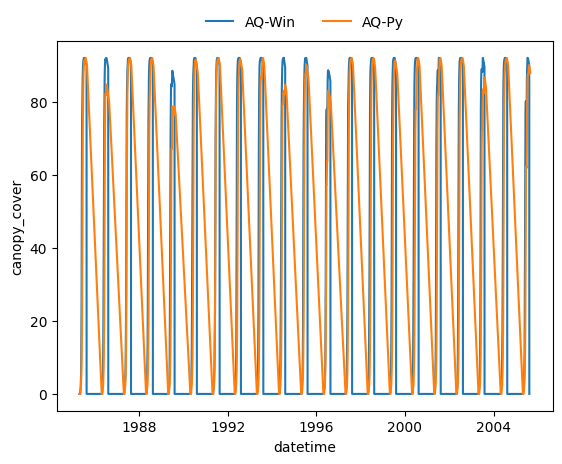

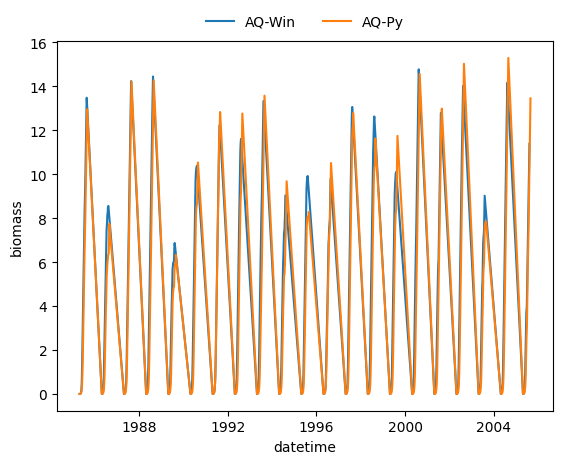

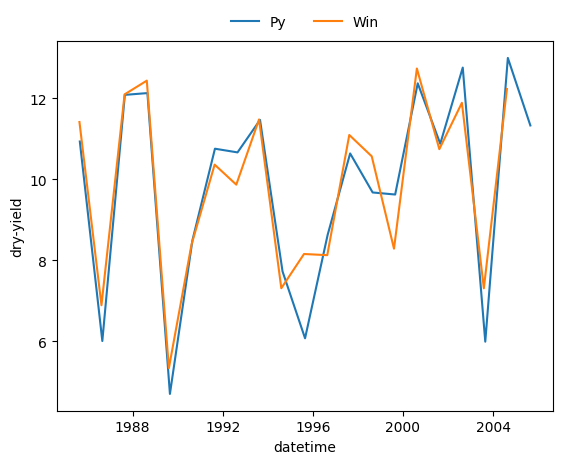

In [ ]:
# Brussels climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocal', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1985}/04/25',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot', model)